In [1]:
import project_path
import os
import json
import re
import pathlib
from multiprocessing import Pool
import numpy as np
from typing import Callable, List, Dict, Any
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
%load_ext autoreload
%autoreload 2

In [19]:
PATHS = {
    #"rollout": "../data/model_output/exp_v10/codegen/att_roll_layer_matrix/Nqueens_Q1.cpp_0_Salesforce_codegen-16B-multi.npy",
    # hannoi_Q2.cpp_2_Salesforce_codegen-16B-multi.npy
    "rollout": "../data/model_output/exp_v10/codegen/att_roll_layer_matrix/hannoi_Q2.cpp_2_Salesforce_codegen-16B-multi.npy",

    #"transitive": "../data/model_output/exp_v10/codegen/att_trans_layer_matrix_left_50_50/Nqueens_Q1.cpp_0_Salesforce_codegen-16B-multi.npy",
    # hannoi_Q2.cpp_2_Salesforce_codegen-16B-multi.npy
    "transitive": "../data/model_output/exp_v10/codegen/att_trans_layer_matrix_left/hannoi_Q2.cpp_2_Salesforce_codegen-16B-multi.npy"
}

In [20]:
MATRICES = {
    k: np.load(v) for k, v in PATHS.items()
}

In [21]:
a = MATRICES["rollout"]
b = MATRICES["transitive"]
np.allclose(a, b)

False

In [22]:
a.shape

(34, 380, 380)

In [23]:
b.shape

(34, 380, 380)

In [24]:
np.allclose(a[-1], b[-1])

False

In [25]:
a[-1][:5, :5]

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [9.99999990e-01, 8.63766430e-42, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [9.99999974e-01, 7.06509061e-41, 5.46642566e-54, 0.00000000e+00,
        0.00000000e+00],
       [9.99999989e-01, 3.04282921e-38, 2.72268635e-40, 3.22577244e-41,
        0.00000000e+00],
       [9.99999927e-01, 1.89907754e-35, 7.80412707e-37, 1.19379603e-37,
        1.16695021e-38]])

In [26]:
b[-1][:5, :5]

array([[3.9511625e+37, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00],
       [3.9511622e+37, 1.3380342e+04, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00],
       [3.9511625e+37, 6.5153156e+04, 4.5771151e+00, 0.0000000e+00,
        0.0000000e+00],
       [3.9511627e+37, 3.2311978e+06, 9.5773664e+04, 2.0191324e+04,
        0.0000000e+00],
       [3.9511620e+37, 2.3063386e+08, 1.6917076e+07, 4.2295890e+06,
        6.1862412e+05]], dtype=float32)

In [27]:
from attwizard.analysis_pass.transformation_functions import normalize_both_matrices_by_line

In [28]:
a2, b2 = normalize_both_matrices_by_line(a, b, None, None)

/home/eaftan/copilot-attention/venv/lib/python3.8/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


In [29]:
a2[-1][:5, :5]

array([[2.63157894e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [2.63157892e-03, 5.78185950e-30, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [2.63157887e-03, 4.72921381e-29, 4.50526143e-42, 0.00000000e+00,
        0.00000000e+00],
       [2.63157891e-03, 2.03680189e-26, 2.24395511e-28, 2.61737738e-29,
        0.00000000e+00],
       [2.63157875e-03, 1.27120008e-23, 6.43192369e-25, 9.68640777e-26,
        9.27731150e-27]])

In [30]:
b2[-1][:5, :5]

array([[1.16114236e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [1.16114229e-01, 1.96371114e-23, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [1.16114236e-01, 9.56193639e-23, 8.26275638e-27, 0.00000000e+00,
        0.00000000e+00],
       [1.16114244e-01, 4.74213517e-21, 1.72893723e-22, 3.57029674e-23,
        0.00000000e+00],
       [1.16114222e-01, 3.38480342e-19, 3.05392530e-20, 7.47889939e-21,
        1.06240222e-21]], dtype=float32)

In [80]:
def normalize_machine_by_number_of_followers(a, b):
    """Normalize the columns times number of followers.
    
    This gives less weights to the columns with a lot of followers (e.g. the 
    first token).
    """
    assert len(a.shape) == 2, "machine data must be a matrix"
    n_tokens = a.shape[0]
    normalizing_vector = np.arange(n_tokens, 0, step=-1)
    # create a vector of squares
    #normalizing_vector = normalizing_vector ** 3
    normalizing_vector = np.broadcast_arrays(normalizing_vector, np.zeros((n_tokens, n_tokens)))[0]
    a = a / normalizing_vector
    return a, b

/tmp/ipykernel_957914/446228740.py:7: RuntimeWarning: divide by zero encountered in log
  matrix = np.log(matrix)


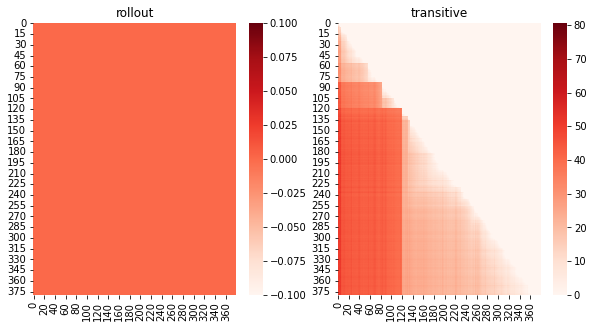

In [87]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

i = 0
for m, title in zip([a, b], ["rollout", "transitive"]):
    matrix = m[-1]
    matrix = normalize_machine_by_number_of_followers(matrix, None)[0]
    matrix = np.log(matrix)
    # clip all the negative values
    matrix[matrix < 0] = 0
    sns.heatmap(
        data=matrix, 
        cmap="Reds",
        ax=axes[i],
    )
    axes[i].set_title(title)
    i += 1



(0.0, 1.0)

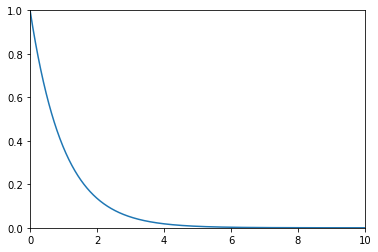

In [96]:
N_SEC = 10
# plot exponential decay function
x = np.arange(0, N_SEC, 0.01)
y = np.exp(-x)
plt.plot(x, y)
plt.xlim(0, N_SEC)
plt.ylim(0, 1)

Text(0.5, 0, 'Time (sec.)')

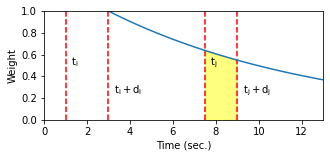

In [13]:
N_SEC = 10
# plot exponential decay function
t_i = 1
t_i_end = 3
t_j = 7.5
t_j_end = 9
x = np.arange(0, t_i_end + N_SEC, 0.01)
y = np.exp(-0.1*(x - t_i_end))

fix, ax = plt.subplots(figsize=(5, 2))
# draw all the vertical lines
ax.axvline(x=t_i, color="r", linestyle="--")
ax.axvline(x=t_i_end, color="r", linestyle="--")
ax.axvline(x=t_j, color="r", linestyle="--")
ax.axvline(x=t_j_end, color="r", linestyle="--")
ax.text(t_i + 0.25, 0.5, "$\mathregular{t_i}$")
ax.text(t_i_end + 0.25, 0.25, "$\mathregular{t_i + d_i}$")
ax.text(t_j + 0.25, 0.5, "$\mathregular{t_j}$")
ax.text(t_j_end + 0.25, 0.25, "$\mathregular{t_j + d_j}$")

ax.plot(x, y)
# fill the plot between the last two vertical lines
ax.fill_between(x, y, 0, where=(x > t_j) & (x < t_j_end), color="yellow", alpha=0.5)
ax.set_xlim(0, t_i_end + N_SEC)
ax.set_ylim(0, 1)
ax.set_ylabel("Weight")
ax.set_xlabel("Time (sec.)")